In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
)
from yellowbrick.cluster import SilhouetteVisualizer


c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# itterate through all the files in the directory and save to pandas dataframe
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('cic_data')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

# Drop non-numeric columns
features = df.select_dtypes(include=[np.number]).copy()

# Replace inf/-inf with NaN
features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values (from infs or missing values)
features.dropna(inplace=True)


# Make sure we drop corresponding rows in original df
df = df.loc[features.index].copy()

 38%|███▊      | 3/8 [00:04<00:06,  1.38s/it]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DoS" in label or label == "DDoS":
        return "DoS/DDoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [ ]:
df["label_group"].value_counts()

label_group
DoS/DDoS      379737
Scan          158804
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [ ]:
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def cluster_and_evaluate_hdbscan(df, min_cluster_size=6000):
    # Clean column names
    df.columns = df.columns.str.strip()

    # Select numeric features (excluding labels)
    features = df.select_dtypes(include=[np.number]).drop(columns=['Label', 'label_group'], errors='ignore')

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    df['cluster'] = clusterer.fit_predict(scaled_features)

    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_features)
    df['pca1'], df['pca2'] = components[:, 0], components[:, 1]

    # Plot clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title('HDBSCAN Clusters Visualized with PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate clustering (excluding noise if present)
    if 'Label' in df.columns:
        valid_idx = df['cluster'] != -1  # exclude noise
        if valid_idx.sum() > 0:
            true_labels = df.loc[valid_idx, 'Label'].astype(str)
            pred_clusters = df.loc[valid_idx, 'cluster']

            ari = adjusted_rand_score(true_labels, pred_clusters)
            nmi = normalized_mutual_info_score(true_labels, pred_clusters)
            homogeneity = homogeneity_score(true_labels, pred_clusters)
            completeness = completeness_score(true_labels, pred_clusters)
            v_measure = v_measure_score(true_labels, pred_clusters)

            print(f'Adjusted Rand Index (ARI): {ari:.4f}')
            print(f'Normalized Mutual Info (NMI): {nmi:.4f}')
            print(f'Homogeneity Score: {homogeneity:.4f}')
            print(f'Completeness Score: {completeness:.4f}')
            print(f'V-Measure Score: {v_measure:.4f}')

            print("\nCluster vs. True Label Crosstab:")
            print(pd.crosstab(df.loc[valid_idx, 'cluster'], df.loc[valid_idx, 'Label']))
        else:
            print("All points classified as noise (cluster -1). Try lowering `min_cluster_size`.")

    return df

# Run HDBSCAN clustering
df_clustered = cluster_and_evaluate_hdbscan(df, min_cluster_size=50)


c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


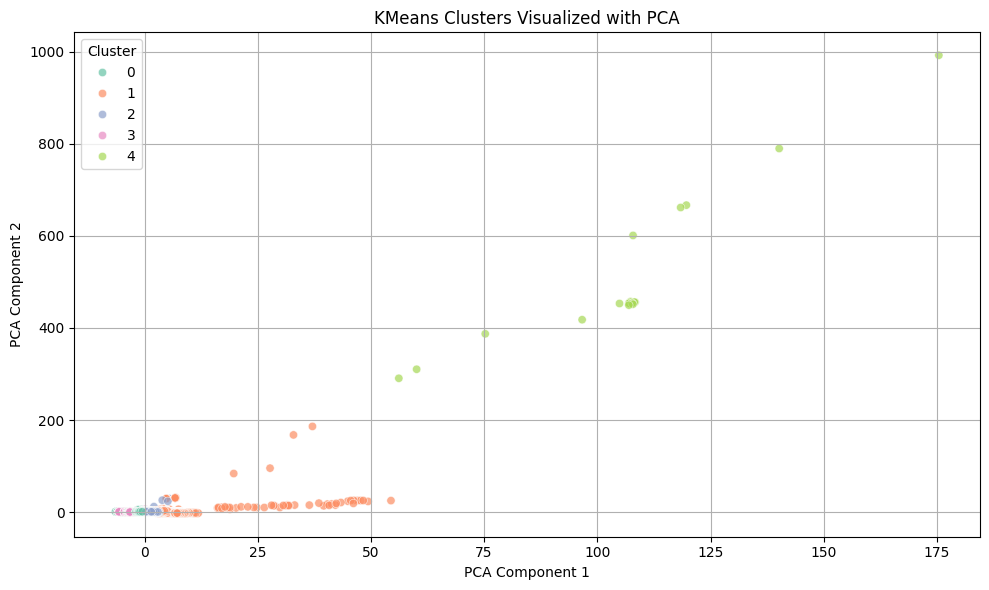

Adjusted Rand Index (ARI): 0.4866
Normalized Mutual Info (NMI): 0.4870
Homogeneity Score: 0.4802
Completeness Score: 0.4939
V-Measure Score: 0.4870

Cluster vs. True Label Crosstab:
Label     Bot   DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
cluster                                                           
0        1206     73           2178      4025              3034   
1          51  21459           1311    141058              1486   
2           0  59866           5125     14501                 0   
3         699  46627           1679     70540               979   
4           0      0              0         0                 0   

Label    DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  \
cluster                                                                   
0                 2022         3974           0             2    158539   
1                 2986            0           1            22       114   
2                    2            0           0 

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def cluster_and_evaluate(df, n_clusters=5):
    # Clean column names
    df.columns = df.columns.str.strip()

    # Select numeric features excluding label
    features = df.select_dtypes(include=[np.number]).drop(columns=['Label', 'label_group'], errors='ignore')

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_features)

    # Reduce to 2D with PCA for visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_features)
    df['pca1'], df['pca2'] = components[:, 0], components[:, 1]

    # Plot clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2', alpha=0.7)
    plt.title('KMeans Clusters Visualized with PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate clusters vs. labels
    if 'Label' in df.columns:
        true_labels = df['Label'].astype(str)
        pred_clusters = df['cluster']

        ari = adjusted_rand_score(true_labels, pred_clusters)
        nmi = normalized_mutual_info_score(true_labels, pred_clusters)
        homogeneity = homogeneity_score(true_labels, pred_clusters)
        completeness = completeness_score(true_labels, pred_clusters)
        v_measure = v_measure_score(true_labels, pred_clusters)

        print(f'Adjusted Rand Index (ARI): {ari:.4f}')
        print(f'Normalized Mutual Info (NMI): {nmi:.4f}')
        print(f'Homogeneity Score: {homogeneity:.4f}')
        print(f'Completeness Score: {completeness:.4f}')
        print(f'V-Measure Score: {v_measure:.4f}')
        
        # Optional: show mapping
        print("\nCluster vs. True Label Crosstab:")
        print(pd.crosstab(df['cluster'], df['Label']))

    return df
df_clustered = cluster_and_evaluate(df)